In [101]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel,RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

In [80]:
#define a dictionary of cover types
CoverTypes={1.0: 'Spruce/Fir',
            2.0: 'Lodgepole Pine',
            3.0: 'Ponderosa Pine',
            4.0: 'Cottonwood/Willow',
            5.0: 'Aspen',
            6.0: 'Douglas-fir',
            7.0: 'Krummholz' }
print 'Tree Cover Types:'
CoverTypes


Tree Cover Types:


{1.0: 'Spruce/Fir',
 2.0: 'Lodgepole Pine',
 3.0: 'Ponderosa Pine',
 4.0: 'Cottonwood/Willow',
 5.0: 'Aspen',
 6.0: 'Douglas-fir',
 7.0: 'Krummholz'}

In [81]:
# creating a directory called covtype, download and decompress covtype.data.gz into it

from os.path import exists
if not exists('covtype'):
    print "creating directory covtype"
    !mkdir covtype
%cd covtype
if not exists('covtype.data'):
    if not exists('covtype.data.gz'):
        print 'downloading covtype.data.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
    print 'decompressing covtype.data.gz'
    !gunzip -f covtype.data.gz
!ls -l
%cd ..

/Users/gaoyue/Desktop/CSE_255/homework/HW5/covtype
total 146816
-rw-r--r--  1 gaoyue  staff  75169317  5 16 14:27 covtype.data
/Users/gaoyue/Desktop/CSE_255/homework/HW5


In [82]:
# Define the feature names
cols_txt="""
Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology,
Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways,
Hillshade_9am, Hillshade_Noon, Hillshade_3pm,
Horizontal_Distance_To_Fire_Points, Wilderness_Area (4 binarycolumns), 
Soil_Type (40 binary columns), Cover_Type
"""

In [111]:
# Break up features that are made out of several binary features.
from string import split,strip
cols=[strip(a) for a in split(cols_txt,',')]
colDict={}
for a in cols:
    colDict[a]=[a]
# colDict={a:[a] for a in cols}
colDict['Soil_Type (40 binary columns)'] = ['ST_'+str(i) for i in range(40)]
colDict['Wilderness_Area (4 binarycolumns)'] = ['WA_'+str(i) for i in range(4)]
Columns=[]
for item in cols:
    Columns=Columns+colDict[item]
print Columns


['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WA_0', 'WA_1', 'WA_2', 'WA_3', 'ST_0', 'ST_1', 'ST_2', 'ST_3', 'ST_4', 'ST_5', 'ST_6', 'ST_7', 'ST_8', 'ST_9', 'ST_10', 'ST_11', 'ST_12', 'ST_13', 'ST_14', 'ST_15', 'ST_16', 'ST_17', 'ST_18', 'ST_19', 'ST_20', 'ST_21', 'ST_22', 'ST_23', 'ST_24', 'ST_25', 'ST_26', 'ST_27', 'ST_28', 'ST_29', 'ST_30', 'ST_31', 'ST_32', 'ST_33', 'ST_34', 'ST_35', 'ST_36', 'ST_37', 'ST_38', 'ST_39', 'Cover_Type']


In [84]:
# Have a look at the first two lines of the data file
!head -2 covtype/covtype.data

2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [85]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='covtype/covtype.data'
inputRDD=sc.textFile(path)
inputRDD.first()

u'2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5'

In [86]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
    .map(lambda x:LabeledPoint(x[len(x)-1],x[:len(x)-1]))
Data.first()

LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])

In [87]:
# count the number of examples of each type
total=Data.cache().count()
print 'total data size=',total
counts=Data.map(lambda x:(x.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
print '              type (label):   percent of total'
print '---------------------------------------------------------'
print '\n'.join(['%20s (%3.1f):\t%4.2f'%(CoverTypes[a[0]],a[0],100.0*a[1]/float(total)) for a in counts])

total data size= 581012
              type (label):   percent of total
---------------------------------------------------------
      Lodgepole Pine (2.0):	48.76
          Spruce/Fir (1.0):	36.46
      Ponderosa Pine (3.0):	6.15
           Krummholz (7.0):	3.53
         Douglas-fir (6.0):	2.99
               Aspen (5.0):	1.63
   Cottonwood/Willow (4.0):	0.47


In [88]:
Label=2.0
Data=inputRDD.map(lambda line: [float(x) for x in line.split(',')])\
    .map(lambda V:LabeledPoint(V[len(V)-1]==Label,V[:len(V)-1]))

In [89]:
Data1=Data.sample(False,0.1).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=58384, trainingData=40858, testData=17526


In [90]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(0.0, 9026), (1.0, 8500)]

In [91]:
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,categoricalFeaturesInfo={},numIterations=10,
                                               maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.2713111947963026, 'train': 0.2758578491360321} 14 seconds
3 {'test': 0.24734679904142418, 'train': 0.25194576337559355} 14 seconds
6 {'test': 0.20381148008672828, 'train': 0.2057614175926379} 16 seconds
10 {'test': 0.16033321921716306, 'train': 0.13346223505800578} 23 seconds
{1: {'test': 0.2713111947963026, 'train': 0.2758578491360321}, 10: {'test': 0.16033321921716306, 'train': 0.13346223505800578}, 3: {'test': 0.24734679904142418, 'train': 0.25194576337559355}, 6: {'test': 0.20381148008672828, 'train': 0.2057614175926379}}


In [92]:
B10 = errors

Populating the interactive namespace from numpy and matplotlib


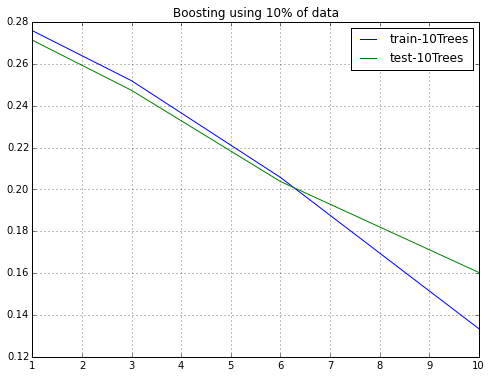

In [105]:
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

In [102]:
from time import time
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData,numClasses=2 ,categoricalFeaturesInfo={},
                                    numTrees=10, featureSubsetStrategy="auto",
                                    impurity='gini', maxDepth=depth, maxBins=32)

    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.3583247746205637, 'train': 0.3632825884771648} 3 seconds
3 {'test': 0.28962684012324547, 'train': 0.29685740858583387} 2 seconds
6 {'test': 0.25276731712883715, 'train': 0.25904351656958247} 2 seconds
10 {'test': 0.23810338925025676, 'train': 0.23779920700964316} 4 seconds
15 {'test': 0.2022709117882004, 'train': 0.19004846052180724} 6 seconds
20 {'test': 0.1841834988017802, 'train': 0.1535562191002986} 10 seconds
{1: {'test': 0.3583247746205637, 'train': 0.3632825884771648}, 3: {'test': 0.28962684012324547, 'train': 0.29685740858583387}, 6: {'test': 0.25276731712883715, 'train': 0.25904351656958247}, 10: {'test': 0.23810338925025676, 'train': 0.23779920700964316}, 15: {'test': 0.2022709117882004, 'train': 0.19004846052180724}, 20: {'test': 0.1841834988017802, 'train': 0.1535562191002986}}


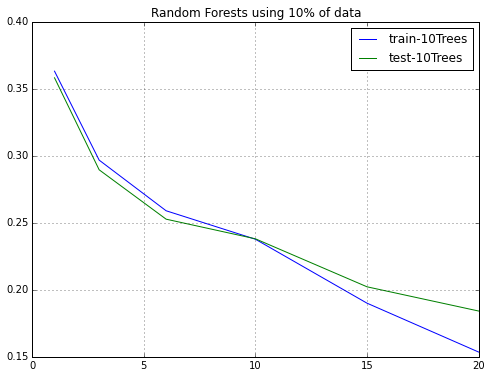

In [106]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')